In [1]:
%load_ext autoreload
%autoreload 2

# Standard libraries
import sys
import time

# Third party libraries
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
import scipy.ndimage
from scipy.ndimage import median_filter
from sklearn.neighbors import KernelDensity

# Our libraries
sys.path.append('../../')
from gui.gui_shared import auto_contrast
from cell import Cell

## Functions

In [2]:
def readTifWrapper(i, file_name):
    """
    i - index for parallel processing
    file_name - file name to open
    """
    image = readTifSection(str(file_name))
    return [i, image]


def readTifSection(file_path):
    """
    Read tif section image using SITK
    """
    image = sitk.ReadImage(str(file_path))
    image = sitk.GetArrayFromImage(image)
    image[image < 0] = 0
    image = image.T
    image = np.flip(image, axis=0)
    image = np.flip(image, axis=1)
    image  = np.squeeze(image)
    return image


def n4_bias_correction(img, alpha=1, shrink_factor=25, show=False):
    """
    N4 bias correction
    """
    # Get contrast image for mask
    contrast_img = auto_contrast(img, alpha=alpha)
    
    # Create the brain tissue mask
    mask_img = sitk.GetImageFromArray(contrast_img)
    mask_img = sitk.RescaleIntensity(mask_img, 0, 255)
    mask_img = sitk.LiThreshold(mask_img, 0, 1)

    # Use the raw image and convert it to float32
    raw_img = sitk.GetImageFromArray(img.copy())
    raw_img = sitk.Cast(raw_img, sitk.sitkFloat32)

    # Downsample it for bias correction
    inputImage = raw_img
    if shrink_factor > 1:
        inputImage = sitk.Shrink( raw_img, [ shrink_factor ] * raw_img.GetDimension() ) #2
        maskImage = sitk.Shrink( mask_img, [ shrink_factor ] * inputImage.GetDimension() ) #3

    # Run bias correction
    start_time = time.time()
    bias_corrector = sitk.N4BiasFieldCorrectionImageFilter()
    corrected = bias_corrector.Execute(inputImage, maskImage)
    
    # Apply bias correction to full resolution image
    log_bias_field = bias_corrector.GetLogBiasFieldAsImage(raw_img)
    corrected_image_full_resolution = raw_img / sitk.Exp(log_bias_field)
    end_time = time.time()
    corrected_image_full_resolution = sitk.GetArrayFromImage(corrected_image_full_resolution)
    
    # Show the process if True
    if show:
        print(f"Time taken for bias correction: {end_time - start_time:.2f} seconds")
        
        # Show the brain tissue mask
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(sitk.GetArrayFromImage(mask_img), cmap='gray')
        plt.title(f"Full resolution brain mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sitk.GetArrayFromImage(maskImage), cmap='gray')
        plt.title(f"Downsampled brain mask (shrink factor={shrink_factor})")
        plt.show()
        
        # Show the log bias field
        plt.figure(figsize=(10, 5))
        plt.imshow(sitk.GetArrayFromImage(log_bias_field))
        plt.colorbar()
        plt.title(f"Log bias field")
        plt.show()

        # Show the corrected bias field image
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(img, cmap='gray')
        plt.title(f"Original raw image")
        plt.subplot(1, 2, 2)
        plt.imshow(corrected_image_full_resolution, cmap='gray')
        plt.title(f"Corrected bias raw image")
        plt.show()

        # Increase the contrast of the corrected image and show side-by-side
        preview_alpha = 0.25
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 2, 1)
        contrast_comparison = auto_contrast(img, alpha=preview_alpha)
        plt.imshow(contrast_comparison, cmap='gray')
        plt.title(f"Original contrast image (alpha={preview_alpha})")
        plt.subplot(1, 2, 2)
        corrected_bias_contrast = auto_contrast(corrected_image_full_resolution, alpha=preview_alpha)
        plt.imshow(corrected_bias_contrast, cmap='gray')
        plt.title(f"Corrected bias contrast image (alpha={preview_alpha})")
        plt.show()
        
    return corrected_image_full_resolution


def show_crop(img, points=None, x_crop=[6100, 7600], y_crop=[2450, 3300], 
              title="Image", cmap='gray', colorbar=False):
    """
    Show the crop of the image
    """
    plt.figure(figsize=(10, 5))
    plt.imshow(img, cmap=cmap)
    if points is not None:
        for point in points:
            plt.plot(point[1], point[0], 'ro', markersize=1)
    plt.title(title)
    if x_crop is not None:
        plt.xlim(x_crop)
    if y_crop is not None:
        plt.ylim(y_crop[::-1])
    if colorbar:
        plt.colorbar()
    plt.show()
    
    
def compute_dice_coefficient(binary_image1, binary_image2):
    """
    Compute the Dice coefficient between two binary images.
    
    Parameters:
    - binary_image1: 2D numpy array representing the first binary image.
    - binary_image2: 2D numpy array representing the second binary image.
    
    Returns:
    - dice_coefficient: The Dice coefficient between the two binary images.
    """
    intersection = np.logical_and(binary_image1, binary_image2)
    return 2. * intersection.sum() / (binary_image1.sum() + binary_image2.sum())


def get_stats(img, title="", show=True):
    """
    Print the statistics of the image.
    """
    img_min = np.min(img)
    img_max = np.max(img)
    img_median = np.median(img)
    img_mean = np.mean(img)
    img_std = np.std(img)
    if show:
        if title:
            print(title)
            prefix = "\t"
        else:
            prefix = ""
        print(f"{prefix}Shape:", img.shape)
        print(f"{prefix}Min:", img_min)
        print(f"{prefix}Max:", img_max)
        print(f"{prefix}Median:", img_median)
        print(f"{prefix}Mean:", img_mean)
        print(f"{prefix}Std:", img_std)
        print()
    return img_min, img_max, img_median, img_mean, img_std
    


def preprocess_image(img, alpha=1, shrink_factor=10, 
                     median_filter_size=5, gaussian_sigma=0.2, 
                     show=False):
    """
    Preprocess the image using N4 bias correction and filtering.
    
    Parameters:
    - img: The input image to preprocess.
    - alpha: The alpha value for contrast adjustment.
    - shrink_factor: The shrink factor for downsampling the image for bias correction.
    - median_filter_size: The size of the median filter to apply.
    - gaussian_sigma: The sigma value for the Gaussian filter to apply.
    - show: Whether to show the intermediate results.
    
    Returns:
    - corrected_img: The preprocessed image.
    """
    corrected_bias_img = n4_bias_correction(img, alpha=alpha, shrink_factor=shrink_factor, show=show)

    # Run median filter
    median_filtered_img = median_filter(corrected_bias_img.copy(), size=median_filter_size)

    # Run gaussian filter
    gaussian_filtered_img = scipy.ndimage.gaussian_filter(median_filtered_img.copy(), sigma=gaussian_sigma)

    if show:
        get_stats(img, title="Original image stats:")
        get_stats(corrected_bias_img, title="N4 bias corrected image stats:")
        get_stats(median_filtered_img, title="Median filtered image stats:")
        get_stats(gaussian_filtered_img, title="Gaussian filtered image stats:")
        
    corrected_img = gaussian_filtered_img        
    return corrected_img

### Load in tiff data

Brain shape: (8716, 11236)
Ground truth (section 140) shape: (66, 2)


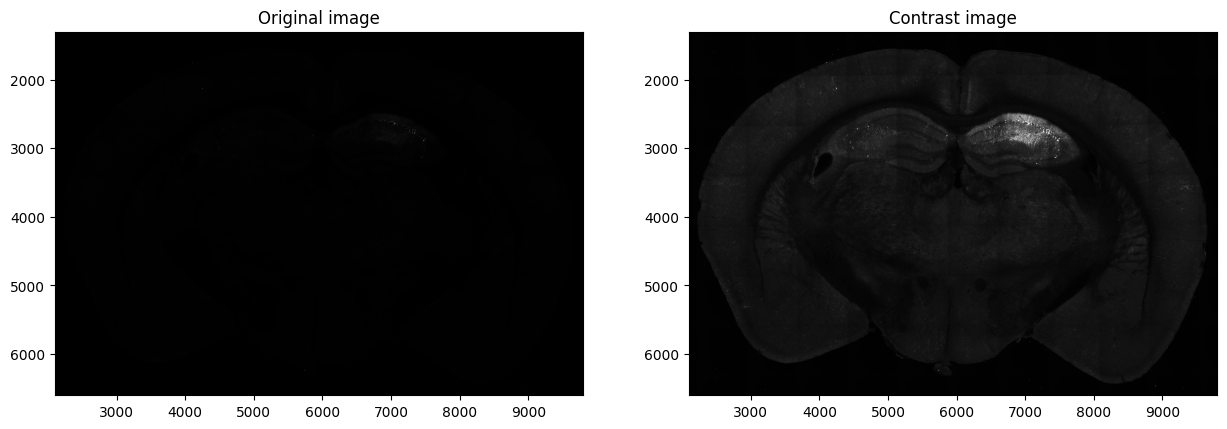

In [3]:
# Parameters for loading in the data
ch0_path = "/media/data/u01/B0039/stitched_ch0/230628_B0039_PG_U01_280-0140_1_0.tif"
ch1_path = "/media/data/u01/B0039/stitched_ch1/230628_B0039_PG_U01_280-0140_1_1.tif"
ch2_path = "/media/data/u01/B0039/stitched_ch2/230628_B0039_PG_U01_280-0140_1_2.tif"
ch3_path = "/media/data/u01/B0039/stitched_ch3/230628_B0039_PG_U01_280-0140_1_3.tif"
gt140_path = "/media/data/u01/B0039/red_section140_counts_240930_PG/red_section140_counts_240930_PG.txt"

# Load in the images
ch0 = readTifSection(ch0_path)
#ch1 = readTifSection(ch1_path)
#ch2 = readTifSection(ch2_path)
#ch3 = readTifSection(ch3_path)
img = ch0

print("Brain shape:", img.shape)

gt_points = np.loadtxt(gt140_path, skiprows=2)
gt_points = gt_points[:, 1:]  # Remove section index row
print("Ground truth (section 140) shape:", gt_points.shape)

# Contrast section
contrast_img = auto_contrast(img, alpha=0.1)

# Plot the image and contrast image
x_boundary = (2100, 9800)  # Crop out most of the background
y_boundary = (1300, 6600)
x_dca1_boundary = (6100, 7600)  # Crop the section to the region of interest
y_dca1_boundary = (2450, 3300)
x_roi_boundary = (7100, 7400)  # Crop the section to the region of interest
y_roi_boundary = (2600, 2900)

plt.figure(figsize=(15, 5))  # 20, 10
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title(f"Original image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.subplot(1, 2, 2)

plt.imshow(contrast_img, cmap='gray')
plt.title(f"Contrast image")
plt.xlim(x_boundary)
plt.ylim(y_boundary[::-1])
plt.show()

Perform N4 bias correction and filtering preprocessing

https://medium.com/@alexandro.ramr777/how-to-do-bias-field-correction-with-python-156b9d51dd79

In [4]:
corrected_img = preprocess_image(img, alpha=1, shrink_factor=15, 
                                 median_filter_size=5, gaussian_sigma=0.2, 
                                 show=False)
contrast_corrected_img = auto_contrast(corrected_img, alpha=0.25)  # Just for visualization

Corrected image stats:
	Shape: (8716, 11236)
	Min: 0.0
	Max: 25210.8440939318
	Median: 17.818282875511834
	Mean: 64.2367677816755
	Std: 105.76834962780245

Threshold value: 2179.6037603377245


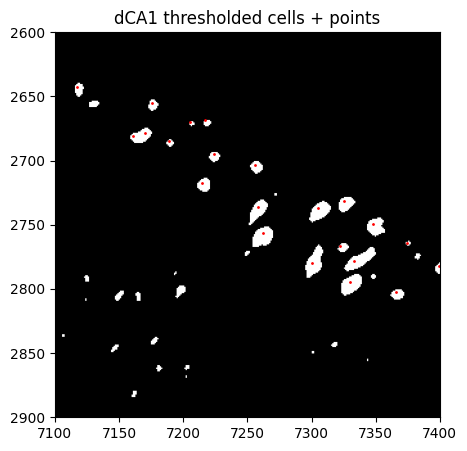

In [5]:
gaussian_img_min, gaussian_img_max, gaussian_img_median, gaussian_img_mean, gaussian_img_std = get_stats(corrected_img, title="Corrected image stats:")
threshold_value = gaussian_img_mean + 20 * gaussian_img_std
print("Threshold value:", threshold_value)

thresholded_img = np.where(corrected_img > threshold_value, 1, 0).astype(bool)  # Binarize
show_crop(thresholded_img, points=gt_points, x_crop=x_roi_boundary, y_crop=y_roi_boundary, title=f"dCA1 thresholded cells + points", cmap='gray')

## Section class

https://pythonspeed.com/articles/numpy-memory-footprint/

In [6]:
from skimage.measure import label, regionprops
import pandas as pd
from collections import defaultdict
from cell import Cell
import tqdm
import pickle
import numpy as np


# Extract the binary image for the biggest connected component
def get_component_binary_image(labeled_image, component_index):
    """
    Extract the binary image for a specific connected component index.
    
    Parameters:
    - labeled_image: Labeled image with connected components.
    - component_index: Index of the connected component to extract.
    
    Returns:
    - component_binary_image: Binary image of the extracted component.
    """
    component_binary_image = (labeled_image == component_index).astype(np.uint8)
    return component_binary_image


class Section:
    def __init__(self, img, index):
        self.image = img
        self.index = index
        
        self.labeled_image = None
        self.cells = defaultdict()
        self.df = None

    
    def process(self, alpha=1, shrink_factor=15, 
                median_filter_size=5, gaussian_sigma=0.2, threshold_scale=20):
        """
        Process the section image and populate the regions and cells.
        """
        # Perform bias correction and filtering
        corrected_image = preprocess_image(self.image.copy(), alpha=alpha, shrink_factor=shrink_factor, 
                                           median_filter_size=median_filter_size, gaussian_sigma=gaussian_sigma, 
                                           show=False)
        
        # Compute thresholding
        _, _, _, img_mean, img_std = get_stats(corrected_image, show=False)
        threshold_value = img_mean + threshold_scale * img_std
        thresholded_img = np.where(corrected_image > threshold_value, 1, 0).astype(bool)
        
        # Label connected components
        self.labeled_image = label(thresholded_img)
        regions = regionprops(self.labeled_image)
        print(f"Number of regions found: {len(regions)}")
        
        # Populate dataframe with cell information
        df_data = []
        
        for region in tqdm.tqdm(regions, desc="Processing regions"):
            component_label = region.label
            component = get_component_binary_image(self.labeled_image, component_label)
            cell = Cell(component, z=self.index, index=component_label)
            self.cells[int(region.label)] = cell
            cell_area, convexity, eccentricity, ellipse_dice, _, _, _ = cell.get_stats(show=False)  # Shape, centroid, medoid
            df_data.append({'Label': component_label, 'Area': cell_area, 'Convexity': convexity, 'Eccentricity': eccentricity, 'Ellipse Dice': ellipse_dice})
        
        #Parallel(n_jobs=5, verbose=13)(delayed(self.append_df)(df_data, region) for region in regions)
        
        self.df = pd.DataFrame(df_data)
        #regions_df = regions_df.sort_values(by='Area', ascending=False)
        #regions_df
    

    def append_df(self, df_data, region):
        """
        Read tif section image using SITK
        """
        component_label = region.label
        component = get_component_binary_image(self.labeled_image, component_label)
        cell = Cell(component, z=self.index, index=component_label)
        self.cells[int(region.label)] = cell
        cell_area, convexity, eccentricity, ellipse_dice, _, _, _ = cell.get_stats()  # Shape, centroid, medoid
        df_data.append({'Label': component_label, 'Area': cell_area, 'Convexity': convexity, 'Eccentricity': eccentricity, 'Ellipse Dice': ellipse_dice})


    def sort(self, key='area', ascending=False):
        df = self.df.rename(columns=str.lower)
        df = df.sort_values(by=key.lower(), ascending=ascending)
        return df
        
        
    def get_df(self):
        return self.df
    
    
    def remove(self, key):
        self.df = self.df[self.df['Label'] != key]
        del self.cells[key]
        self.labeled_image[self.labeled_image == key] = 0
        
    
    def save(self, path):
        with open(path, 'wb') as file:
            pickle.dump(self, file)
    
    
    def __len__(self):
        return len(self.cells)
    
    
    def __str__(self):
        return f"Section {self.index}"
    
    
    def __repr__(self):
        return self.__str__()
    
    
    def __getitem__(self, key):
        return self.cells[key]

In [7]:
section = np.load("section139_coo.pkl", allow_pickle=True)
#section = Section(img, 139)
#section.process()
#print("Done processing section")
#section.save("section139_coo.pkl")

In [8]:
sample_df = section.sort(key='area')
sample_df

,label,area,convexity,eccentricity,ellipse dice
15,16,849,0.438307,0.837417,0.477987
63,64,211,0.959091,0.895812,0.868735
65,66,209,0.958716,0.946358,0.898551
126,127,198,0.994975,0.849247,0.900256
52,53,196,0.994924,0.705928,0.906250
...,...,...,...,...,...
89,90,2,0.000000,0.816497,0.800000
150,151,2,0.000000,0.816497,0.800000
87,88,2,0.000000,0.816497,0.800000
125,126,1,0.000000,0.122682,1.000000


## Create dataframe test

In [9]:
# Label connected components
labeled_image = label(thresholded_img)

# Get properties of labeled regions
regions = regionprops(labeled_image)

# Create a DataFrame to store the label index and area of each region
regions_data = []


# Find the index of the biggest connected component

max_area = 0
max_area_label = 0
for region in regions:
    if region.area > max_area:
        max_area = region.area
        max_area_label = region.label
    regions_data.append({'Label': region.label, 'Area': region.area})

print("Max area label:", max_area_label)
biggest_component_binary_image = get_component_binary_image(labeled_image, max_area_label)
#np.save("data/branching_component.npy", biggest_component_binary_image)
regions_df = pd.DataFrame(regions_data)
regions_df = regions_df.sort_values(by='Area', ascending=False)
regions_df

Max area label: 16


,Label,Area
15,16,849
63,64,211
65,66,209
126,127,198
52,53,196
...,...,...
89,90,2
150,151,2
87,88,2
125,126,1


## Run sample tests with the Cell class

In [10]:
from cell import Cell

def show_cell_label(label: int, labeled_image: np.ndarray, contrast_img: np.ndarray=None, spacing=12):
    """
    Show the labeled cell with the specified label.
    
    Parameters:
    - label: The label of the cell to show.
    - contrast_img: The contrast image to overlay the cell on.
    """
    # Get the binary image for the cell
    cell_region = get_component_binary_image(labeled_image, label)
    

    # Create a Cell object
    cell = Cell(cell_region, 139, label)
    
    # Show the cell
    cell.show(contrast_img)
    cell.locate(contrast_img, spacing=spacing)
    _ = cell.get_stats(corrected_img)
    print()

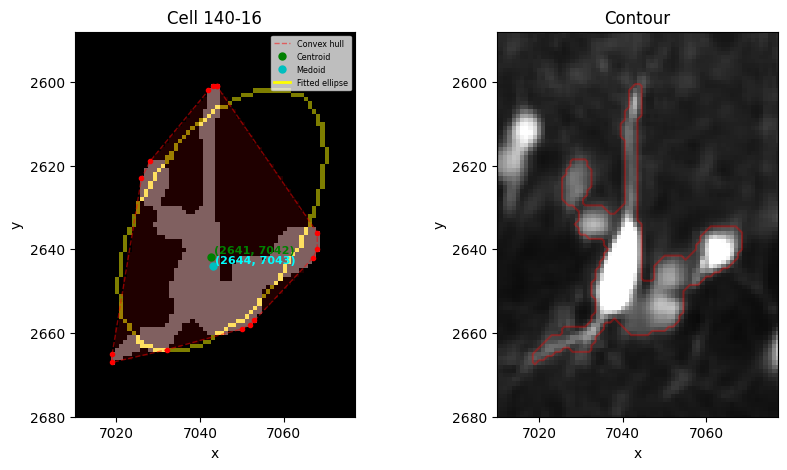

Elapsed time: 0.009016990661621094


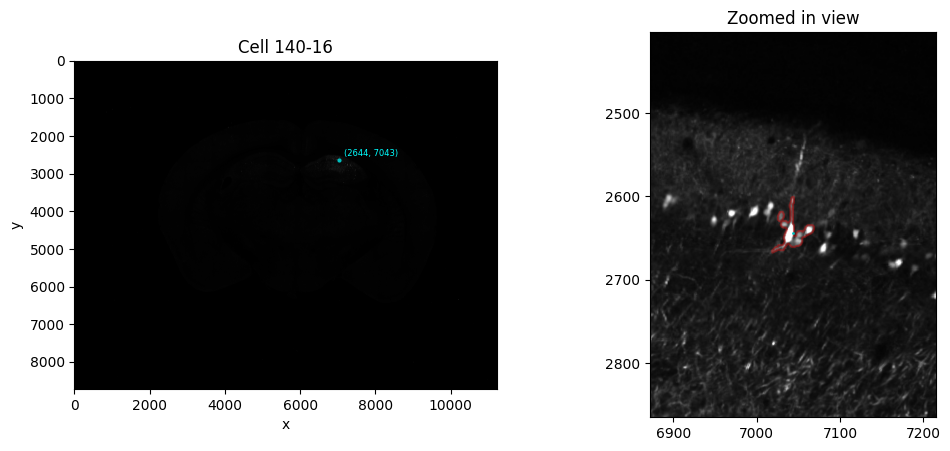

Cell 140-16
  Geometric stats
      Cell area: 849 pixels
      Convexity: 0.43830665978316985
      Eccentricity: 0.8374173092019966
      Ellipse Dice coefficient: 0.4779874213836478
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2641.733804475854, 7042.679623085984)
      Medoid: (2644, 7043)
  Intensity stats
      Min: 2184.0682157354536
      Max: 23910.078407610246
      Median: 3506.830579304873
      Mean: 5497.640987875636
      Std: 4865.312714262219



In [11]:
branching_cell = np.load("data/branching_component.npy")
contrast_img = auto_contrast(img, alpha=0.025)

cell = Cell(branching_cell, 140, max_area_label)
cell.show(contrast_img)
cell.locate(contrast_img)
_ = cell.get_stats(corrected_img)

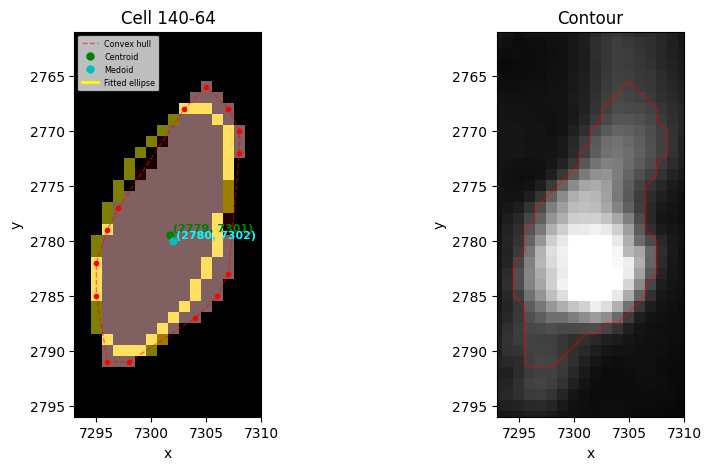

Elapsed time: 0.009087085723876953


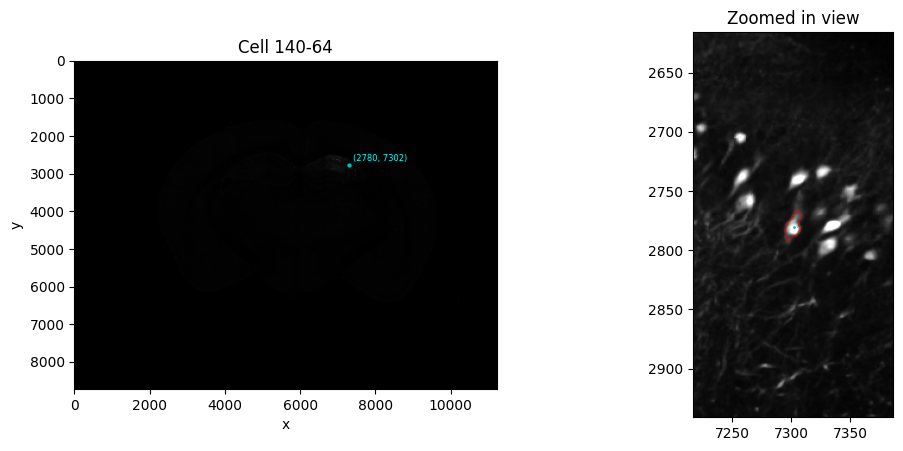

Cell 140-64
  Geometric stats
      Cell area: 211 pixels
      Convexity: 0.9590909090909091
      Eccentricity: 0.895811940533499
      Ellipse Dice coefficient: 0.8687350835322196
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2779.445497630332, 7301.677725118483)
      Medoid: (2780, 7302)
  Intensity stats
      Min: 2186.6518190196607
      Max: 10197.684328346579
      Median: 4196.536452835768
      Mean: 4867.374314211183
      Std: 2367.8783891331086



In [12]:
area_label = 64
cell = Cell(get_component_binary_image(labeled_image, area_label), 140, area_label)
cell.show(contrast_img)
cell.locate(contrast_img, spacing=6)
_ = cell.get_stats(corrected_img)

In [13]:
regions_df['Label'].tolist()

[16,
 64,
 66,
 127,
 53,
 75,
 14,
 48,
 10,
 47,
 17,
 51,
 34,
 111,
 19,
 46,
 31,
 145,
 13,
 107,
 92,
 20,
 42,
 11,
 8,
 94,
 41,
 22,
 119,
 82,
 146,
 70,
 136,
 3,
 39,
 89,
 27,
 152,
 15,
 142,
 96,
 23,
 38,
 29,
 18,
 80,
 61,
 24,
 60,
 81,
 28,
 21,
 143,
 79,
 141,
 62,
 122,
 30,
 84,
 44,
 40,
 97,
 102,
 154,
 7,
 155,
 56,
 137,
 43,
 71,
 112,
 2,
 36,
 32,
 26,
 101,
 158,
 87,
 144,
 85,
 78,
 35,
 104,
 9,
 131,
 63,
 110,
 52,
 68,
 86,
 124,
 77,
 114,
 157,
 103,
 72,
 135,
 69,
 65,
 54,
 4,
 123,
 133,
 163,
 5,
 37,
 67,
 98,
 76,
 115,
 91,
 59,
 33,
 49,
 132,
 25,
 148,
 130,
 125,
 139,
 134,
 50,
 162,
 156,
 108,
 161,
 160,
 116,
 73,
 147,
 58,
 83,
 129,
 128,
 149,
 95,
 117,
 138,
 57,
 150,
 153,
 12,
 45,
 1,
 106,
 74,
 100,
 99,
 118,
 93,
 105,
 113,
 121,
 140,
 6,
 109,
 159,
 120,
 90,
 151,
 88,
 126,
 55]

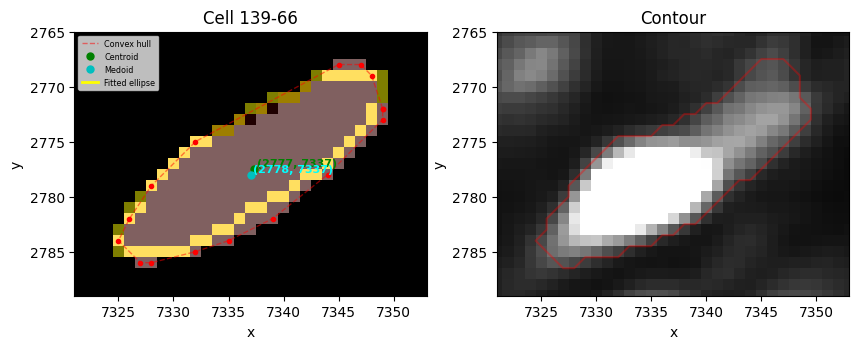

Elapsed time: 0.008854866027832031


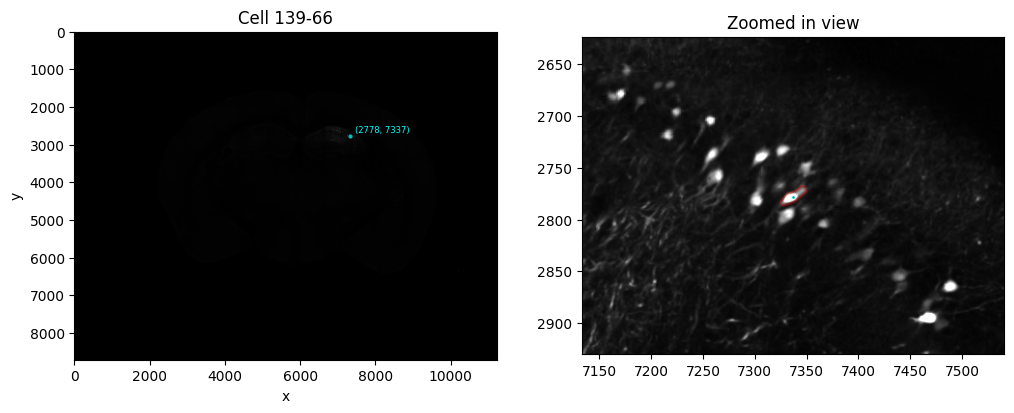

Cell 139-66
  Geometric stats
      Cell area: 209 pixels
      Convexity: 0.9587155963302753
      Eccentricity: 0.9463581987338892
      Ellipse Dice coefficient: 0.8985507246376812
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2777.4832535885166, 7337.315789473684)
      Medoid: (2778, 7337)
  Intensity stats
      Min: 2188.4161899827373
      Max: 17058.96818113412
      Median: 5076.108555230147
      Mean: 6959.044502557572
      Std: 4535.023549297472




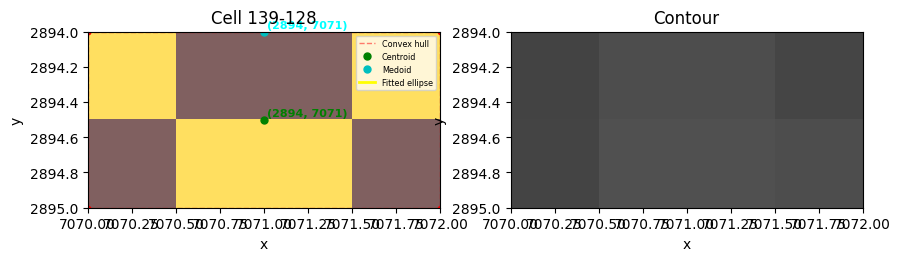

Elapsed time: 0.00898599624633789


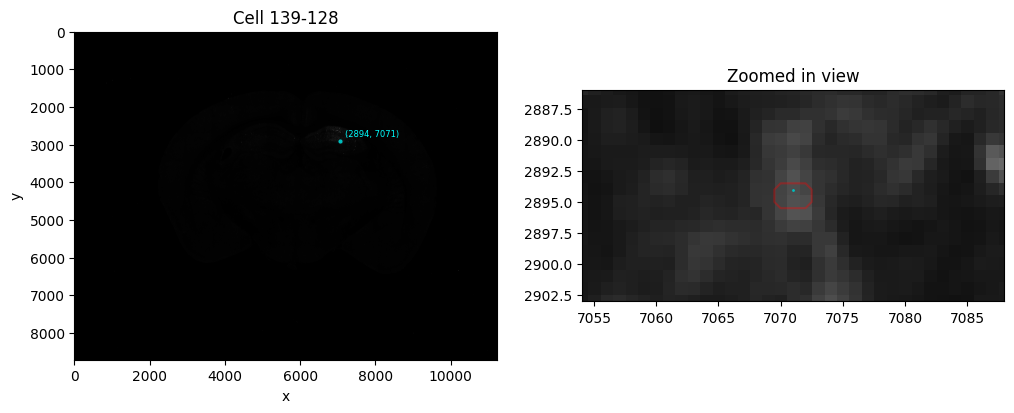

Cell 139-128
  Geometric stats
      Cell area: 6 pixels
      Convexity: 1.0
      Eccentricity: 0.7548401668511083
      Ellipse Dice coefficient: 0.7272727272727273
  Image stats
      Image shape: (8716, 11236)
      Centroid: (2894.5, 7071.0)
      Medoid: (2894, 7071)
  Intensity stats
      Min: 2270.3875674833575
      Max: 2349.0034130113854
      Median: 2309.6957682244974
      Mean: 2309.6954755678257
      Std: 39.30662975544478




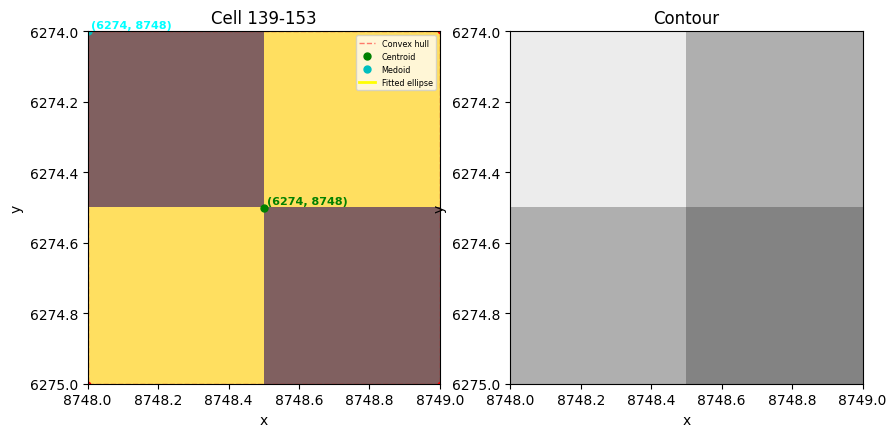

Elapsed time: 0.009346485137939453


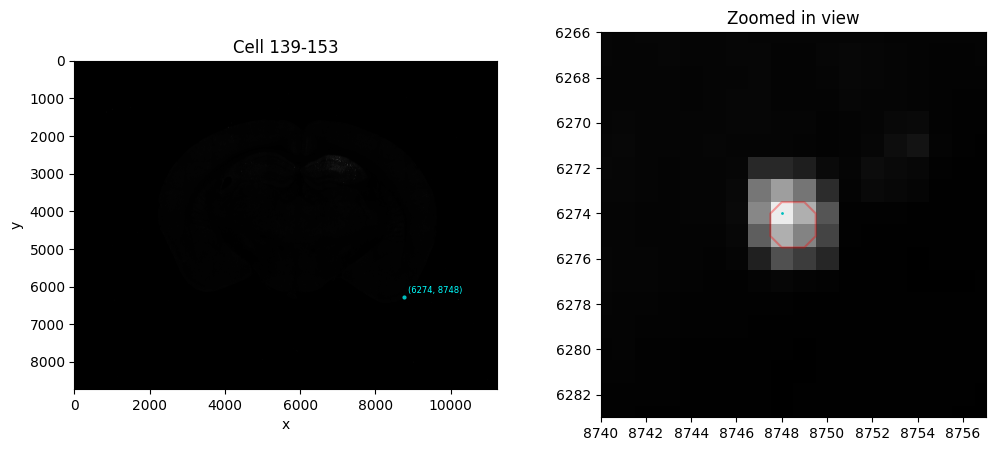

Cell 139-153
  Geometric stats
      Cell area: 4 pixels
      Convexity: 1.0
      Eccentricity: 0.0
      Ellipse Dice coefficient: 0.6666666666666666
  Image stats
      Image shape: (8716, 11236)
      Centroid: (6274.5, 8748.5)
      Medoid: (6274, 8748)
  Intensity stats
      Min: 2565.298178907888
      Max: 2565.308363862631
      Median: 2565.3034310381618
      Mean: 2565.3033512117104
      Std: 0.004865593966847838




In [14]:
show_cell_label(66, labeled_image, contrast_img, spacing=8)
show_cell_label(128, labeled_image, contrast_img, spacing=8)
show_cell_label(153, labeled_image, contrast_img, spacing=8)